## Introduction
 This notebbook is meant to recreate the results of the Section 4.1 Of Mean Variance Portfolio optimization.
 A Nominal model is constructed with synthetic parameters leading to a Multi-variate normal distribution.
 The Robust portfolio is constructed by allowing some model perturbation but retaining the  mean vector.

In [1]:
import numpy as np
from numpy.linalg import det, inv, eigvalsh

import scipy
from scipy.optimize import minimize, Bounds #LinearConstraint

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Synthetic parameters for Nominal model
# Description - 10 stocks with same parameters 
mu_i = 0.1
sig_ii = 0.3
rho_ij = 0.25
n = 10

gamma = 1

# the mean vector and covariance matrix of the Gaussian Distribution
mu = np.full(n, mu_i)
Sigma = np.full((n, n), rho_ij*sig_ii*sig_ii)

# Set the diagonal elements to the diagonal value
np.fill_diagonal(Sigma, sig_ii*sig_ii)

Experiment for a single $\theta$ value

Nominal Portfolio

In [4]:
def portfolio_risk(a, mu, Sigma, gamma):
    return -a.T @ mu + (gamma / 2) * a.T @ Sigma @ a

# Function to calculate worst-case covariance matrix
def worst_case_covariance_matrix(Sigma, theta, gamma, a):
    inv_Sigma_wc = inv(Sigma) - theta * gamma * np.outer(a, a)
    return inv(inv_Sigma_wc)

In [3]:
#one = np.full(n, 1) 
a_hat = (1/gamma)* inv(Sigma) @ mu
print("Optimal Weights", a_hat)

Optimal Weights [0.34188034 0.34188034 0.34188034 0.34188034 0.34188034 0.34188034
 0.34188034 0.34188034 0.34188034 0.34188034]


In [5]:
performance_nominal = portfolio_risk(a_hat, mu, Sigma, gamma)
print("Performance in Nominal Model:", performance_nominal)

theta1 = 0.2
# Calculate worst-case covariance matrix
Sigma_tilda = worst_case_covariance_matrix(Sigma, theta1, gamma, a_hat)

# Calculate performance in the worst-case model
performance_wc = portfolio_risk(a_hat, mu, Sigma_tilda, gamma)
print("Performance in Worst-Case Model:", performance_wc)

Performance in Nominal Model: -0.17094017094017097
Performance in Worst-Case Model: -0.15839410334823173


Worst Case Portfolio

In [6]:
I = np.eye(n)

#speciific case for analysis
theta_ = 0.2

def objective_a_oftheta(a, theta):
    term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma))
    return (1/theta)*np.log(term1) - a.T @ mu

def positive_definite_constraint(a, theta):
    eigen_min = eigvalsh(inv(Sigma) - theta * gamma * np.outer(a,a) )
    return eigen_min - 1e-10  # Ensure all eigenvalues are slightly greater than zero


In [7]:
bounds = Bounds(0, np.inf)
# Initial guess for 'a'
a0 = np.ones(n)/n

# Define constraints in the format required by 'minimize'
constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}

# Perform the optimization
result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))

# Check if the optimization was successful
if result.success:
    a_star = result.x
    print("Optimized a:", a_star)
    print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
else:
    print("Optimization failed:", result.message)

Optimized a: [0.32123484 0.32123468 0.32123483 0.32123489 0.32123466 0.32123475
 0.32123482 0.32123475 0.32123482 0.32123476]
 Minimum adjective reached at -0.16556950126828307 Not portfolio objective!


In [8]:
#computaion of entropy, risk_measurement
#mvo = mean variance objective

Rel_entropy = 0.5*(np.log(det(Sigma @ inv(Sigma_tilda) )) + np.trace(inv(Sigma) @ Sigma_tilda - I))

RPs_nominal = portfolio_risk(a_star, mu, Sigma, gamma)

RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)
RPs_worstcase2 = portfolio_risk(a_star, mu, Sigma_tilda, gamma)
# Both of them are the same

print('RPs_nominal ', RPs_nominal)
print('RPs_worstcase ', RPs_worstcase2)
print('Rel_entropy ', Rel_entropy)

RPs_nominal  -0.1703167961000424
RPs_worstcase  -0.1592402467902211
Rel_entropy  0.0012842214221154696


Scipy optimize based optimization

The below section repeats the experiment for a range of $\theta$ values and builds the NP and RP profiles.

In [ ]:
results_ = {}
thetas = (np.exp(np.linspace(0, 1)) - 1)[1:]
for theta_ in thetas:
    # Initial guess for 'a'
    a0 = np.ones(n)/n
    
    # Define constraints in the format required by 'minimize'
    constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk_measurement
    #mvo = mean variance objective
    Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))
    
    Rel_entropy = (np.log(det(Sigma @ inv(Sigma_tilda) )) + np.trace(inv(Sigma) @ Sigma_tilda - I))/2
    
    RPs_nominal = portfolio_risk(a_star, mu, Sigma, gamma)
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

    results_[theta_] = (Rel_entropy, NPs_worstcase, RPs_nominal, RPs_worstcase)

In [10]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'NPs_worstcase', 'RPs_nominal',  'RPs_worstcase'])

We also calculate the Risk Measurement at -ve $\theta$ , which denoted the degree of incorrectness of bounds of model uncertainity.

In [11]:
neg_results_ = {}
neg_thetas = -1 * (np.exp(np.linspace(0, 0.5)) - 1)[1:]
for theta_ in neg_thetas:
    # Initial guess for 'a'
    a0 = np.ones(n)/n 
    
    # Define constraints in the format required by 'minimize'
    constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk_measurement
    #mvo = mean variance objective
    Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))
    
    Rel_entropy = (np.log(det(Sigma @ inv(Sigma_tilda) )) + np.trace(inv(Sigma) @ Sigma_tilda - I))/2
    
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    neg_results_[theta_] = (Rel_entropy, NPs_worstcase)

In [12]:
neg_results_

# Convert the dictionary to a list of tuples
neg_theta_data_list = [(key, *value) for key, value in neg_results_.items()]

# Create a DataFrame
neg_theta_df_wc = pd.DataFrame(neg_theta_data_list, columns=['Theta', 'Entropy', 'NPs_worstcase'])

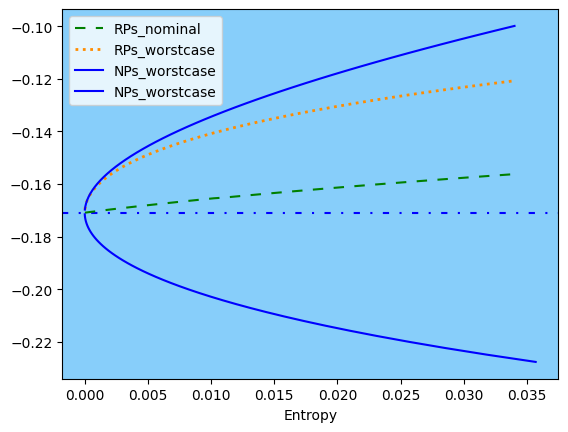

In [13]:
# No bounds no linear constraints just simple results
fig = plt.figure()
#fig.patch.set_facecolor('lightskyblue')
ax = plt.gca()
ax.set_facecolor('lightskyblue')
ax.axhline(y = performance_nominal, color = 'b', linestyle = (0, (3, 5, 1, 5)))  # NP Nominal
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green') # RP Nominal

df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=2, color='darkorange') # RP Robust
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue') # NP Robust
neg_theta_df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue') # RP Robust lower profile
plt.show()

In [14]:
# Adding the sum constraint results in equi-weighted portfolios.

## Parameter Perturbations

Next we show that model error as gauged by relative entropy does not necessarily correspond to a straightforward error in parameters. To illustrate, 
we examine the performance of the nominal portfolio under specific parameter perturbations. 

We vary the common correlation parameter from ρ = 0.14 (which produces the best performance) to ρ = 0.36 (which produces the worst); the
relative entropy first decreases and then increases as ρ moves through this range. We also examine the effect of multiplying
the covariance matrix of the assets by κ ∈ (0.83, 1.18).

In [ ]:
I = np.eye(n)

results_rho_pf = []
results_rho_ent = []
for rho_ij in np.linspace(0.14, 0.36, 30):
    Sigma_change = np.full((n, n), rho_ij*sig_ii*sig_ii)
    
    # Set the diagonal elements to the diagonal value
    np.fill_diagonal(Sigma_change, sig_ii*sig_ii)
    
    a_cap = (1/gamma)* inv(Sigma_change) @ mu
    
    performance_pp = portfolio_risk(a_cap, mu, Sigma_change, gamma)
                    
    Rel_entropy_pp = (np.log(det(Sigma @ inv(Sigma_change) )) + np.trace(inv(Sigma) @ Sigma_change - I))/2
    results_rho_pf.append(performance_pp)
    results_rho_ent.append(Rel_entropy_pp)

In [ ]:
results_kap_pf = []
results_kap_ent = []

for kappa in np.linspace(0.83, 1.18, 30):
    Sigma_change = kappa*Sigma
    
    a_cap = (1/gamma)* inv(Sigma_change) @ mu
        
    performance_pp = portfolio_risk(a_cap, mu, Sigma_change, gamma)
    Rel_entropy_pp = (np.log(det(Sigma @ inv(Sigma_change) )) + np.trace(inv(Sigma) @ Sigma_change - I))/2
    results_kap_pf.append(performance_pp)
    results_kap_ent.append(Rel_entropy_pp)

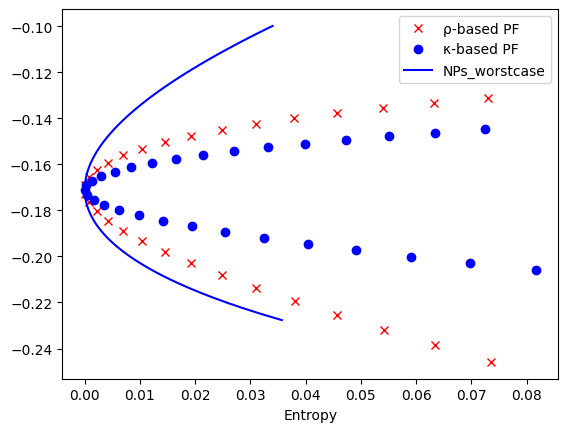

In [24]:
ax = plt.gca()
ax.plot(results_rho_ent, results_rho_pf, 'rx', linewidth=1, label='ρ‐based PF')
ax.plot(results_kap_ent, results_kap_pf, 'bo', linewidth=1, label='κ‐based PF')
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue', label='_nolegend_')
neg_theta_df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
ax.legend(loc='best')
plt.show()